In [2]:
import numpy as np
import random as rand
import pandas as pd

import diff_classifier.msd as msd
import matplotlib.pyplot as plt
import diff_classifier.heatmaps as hm
import diff_classifier.aws as aws
from scipy.ndimage.morphology import distance_transform_edt as eudist

In [18]:
mask = np.zeros((513,513)) > 1

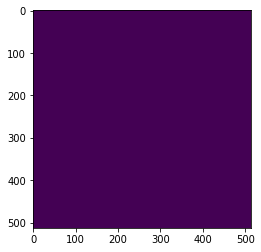

In [19]:
plt.figure(figsize=(4,4))
plt.imshow(mask)

In [14]:
mask

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [15]:
def random_traj_dataset(nframes=100, nparts=30, seed=1, fsize=(0, 512),
                        step=1, mask=None, stuckprob=0.5, ndist=None):
    """Creates a random population of random walks.

    Parameters
    ----------
    nframes : int
        Number of frames for each random trajectory.
    nparts : int
        Number of particles in trajectory dataset.
    seed : int
        Seed for pseudo-random number generator for reproducability.
    fsize : tuple of int or float
        Scope of points over which particles may start at.
    ndist : tuple of int or float
        Parameters to generate normal distribution, mu and sigma.

    Returns
    -------
    dataf : pandas.core.frame.DataFrame
        Trajectory data containing a 'Frame', 'Track_ID', 'X', and
        'Y' column.

    """

    frames = []
    trackid = []
    x = []
    y = []
    start = [0, 0]
    pseed = seed

    for i in range(0, nparts+1):
        rand.seed(a=i+pseed)
        start[0] = rand.randint(fsize[0], fsize[1])
        rand.seed(a=i+3+pseed)
        start[1] = rand.randint(fsize[0], fsize[1])
        rand.seed(a=i+5+pseed)
        if type(ndist) is tuple:
            weight = rand.normalvariate(mu=ndist[0], sigma=ndist[1])
        else:
            weight = 1

        trackid = np.append(trackid, np.array([i]*nframes))
        xi, yi = random_walk(nsteps=nframes, seed=i,
                             start=(start[0], start[1]),
                             step=step+weight , mask=mask,
                             stuckprob=stuckprob)
        x = np.append(x, xi)
        y = np.append(y, yi)
        frames = np.append(frames, np.linspace(0, nframes-1, nframes))

    datai = {'Frame': frames,
             'Track_ID': trackid,
             'X': x,
             'Y': y,
             'Quality': (nframes)*(nparts+1)*[10],
             'SN_Ratio': (nframes)*(nparts+1)*[0.1],
             'Mean_Intensity': (nframes)*(nparts+1)*[120]}
    
    print(len(frames))
    print(len(trackid))
    print(x.shape)
    print(y.shape)
    print(len((nframes)*(nparts+1)*[10]))
    print(len((nframes)*(nparts+1)*[10]))
    print(len((nframes)*(nparts+1)*[10]))
    dataf = pd.DataFrame(data=datai)

    return dataf

In [27]:
def random_walk(nsteps=100, seed=None, start=(0, 0), step=1, mask = None, stuckprob = 0.5):
    if type(mask) is np.ndarray:
        while not mask[start[0], start[1]]:
            start = (start[0], start[1]-1)
            eumask = eudist(~mask)
    np.random.seed(seed=seed)

    x = np.zeros(nsteps)
    y = np.zeros(nsteps)
    x[0] = start[0]
    y[0] = start[1]
    #eumask = eudist(~mask)

    if not type(mask) is np.ndarray: #Checks to see if a mask is being used first
        for i in range(1, nsteps):
            val = rand.randint(1, 4)
            if val == 1:
                x[i] = x[i - 1] + step
                y[i] = y[i - 1]
            elif val == 2:
                x[i] = x[i - 1] - step
                y[i] = y[i - 1]
            elif val == 3:
                x[i] = x[i - 1]
                y[i] = y[i - 1] + step
            else:
                x[i] = x[i - 1]
                y[i] = y[i - 1] - step
    else:
        #print("Applied mask")
        for i in range(1, nsteps):
            val = rand.randint(1, 4)
            # Makes sure within mask dimensions
            if x[i-1] > mask.shape[0] - 1:
                x[i-1] = mask.shape[0] - 1
            elif y[i-1] > mask.shape[0] - 1:
                y[i-1] = mask.shape[0] - 1
        
            if mask[int(x[i-1]), int(y[i-1])]: #If mask is being used, checks if entry is in mask or not
                if val == 1:
                    x[i] = x[i - 1] + step
                    y[i] = y[i - 1]
                elif val == 2:
                    x[i] = x[i - 1] - step
                    y[i] = y[i - 1]
                elif val == 3:
                    x[i] = x[i - 1]
                    y[i] = y[i - 1] + step
                else:
                    x[i] = x[i - 1]
                    y[i] = y[i - 1] - step
            elif np.random.rand() > stuckprob: #If it does cross into a False area, probability to be stuck
                x[i] = x[i - 1]
                y[i] = y[i - 1]
                
                
                while eumask[int(x[i]), int(y[i])] > 0:
                    vals = np.zeros(4)
                    vals[0] = eumask[int(x[i] + step), int(y[i])]
                    vals[1] = eumask[int(x[i] - step), int(y[i])]
                    vals[2] = eumask[int(x[i]), int(y[i] + step)]
                    vals[3] = eumask[int(x[i]), int(y[i] - step)]
                    vali = np.argmin(vals)
                    
                    if vali == 0:
                        x[i] = x[i] + step
                        y[i] = y[i]
                    elif vali == 1:
                        x[i] = x[i] - step
                        y[i] = y[i]
                    elif vali == 2:
                        x[i] = x[i]
                        y[i] = y[i] + step
                    else:
                        x[i] = x[i]
                        y[i] = y[i] - step

            else: #Otherwise, particle is stuck on "cell"
                x[i] = x[i - 1]
                y[i] = y[i - 1]
                

    return x, y

In [35]:
x, y = random_walk(nsteps = 5000)

(-200, 200)

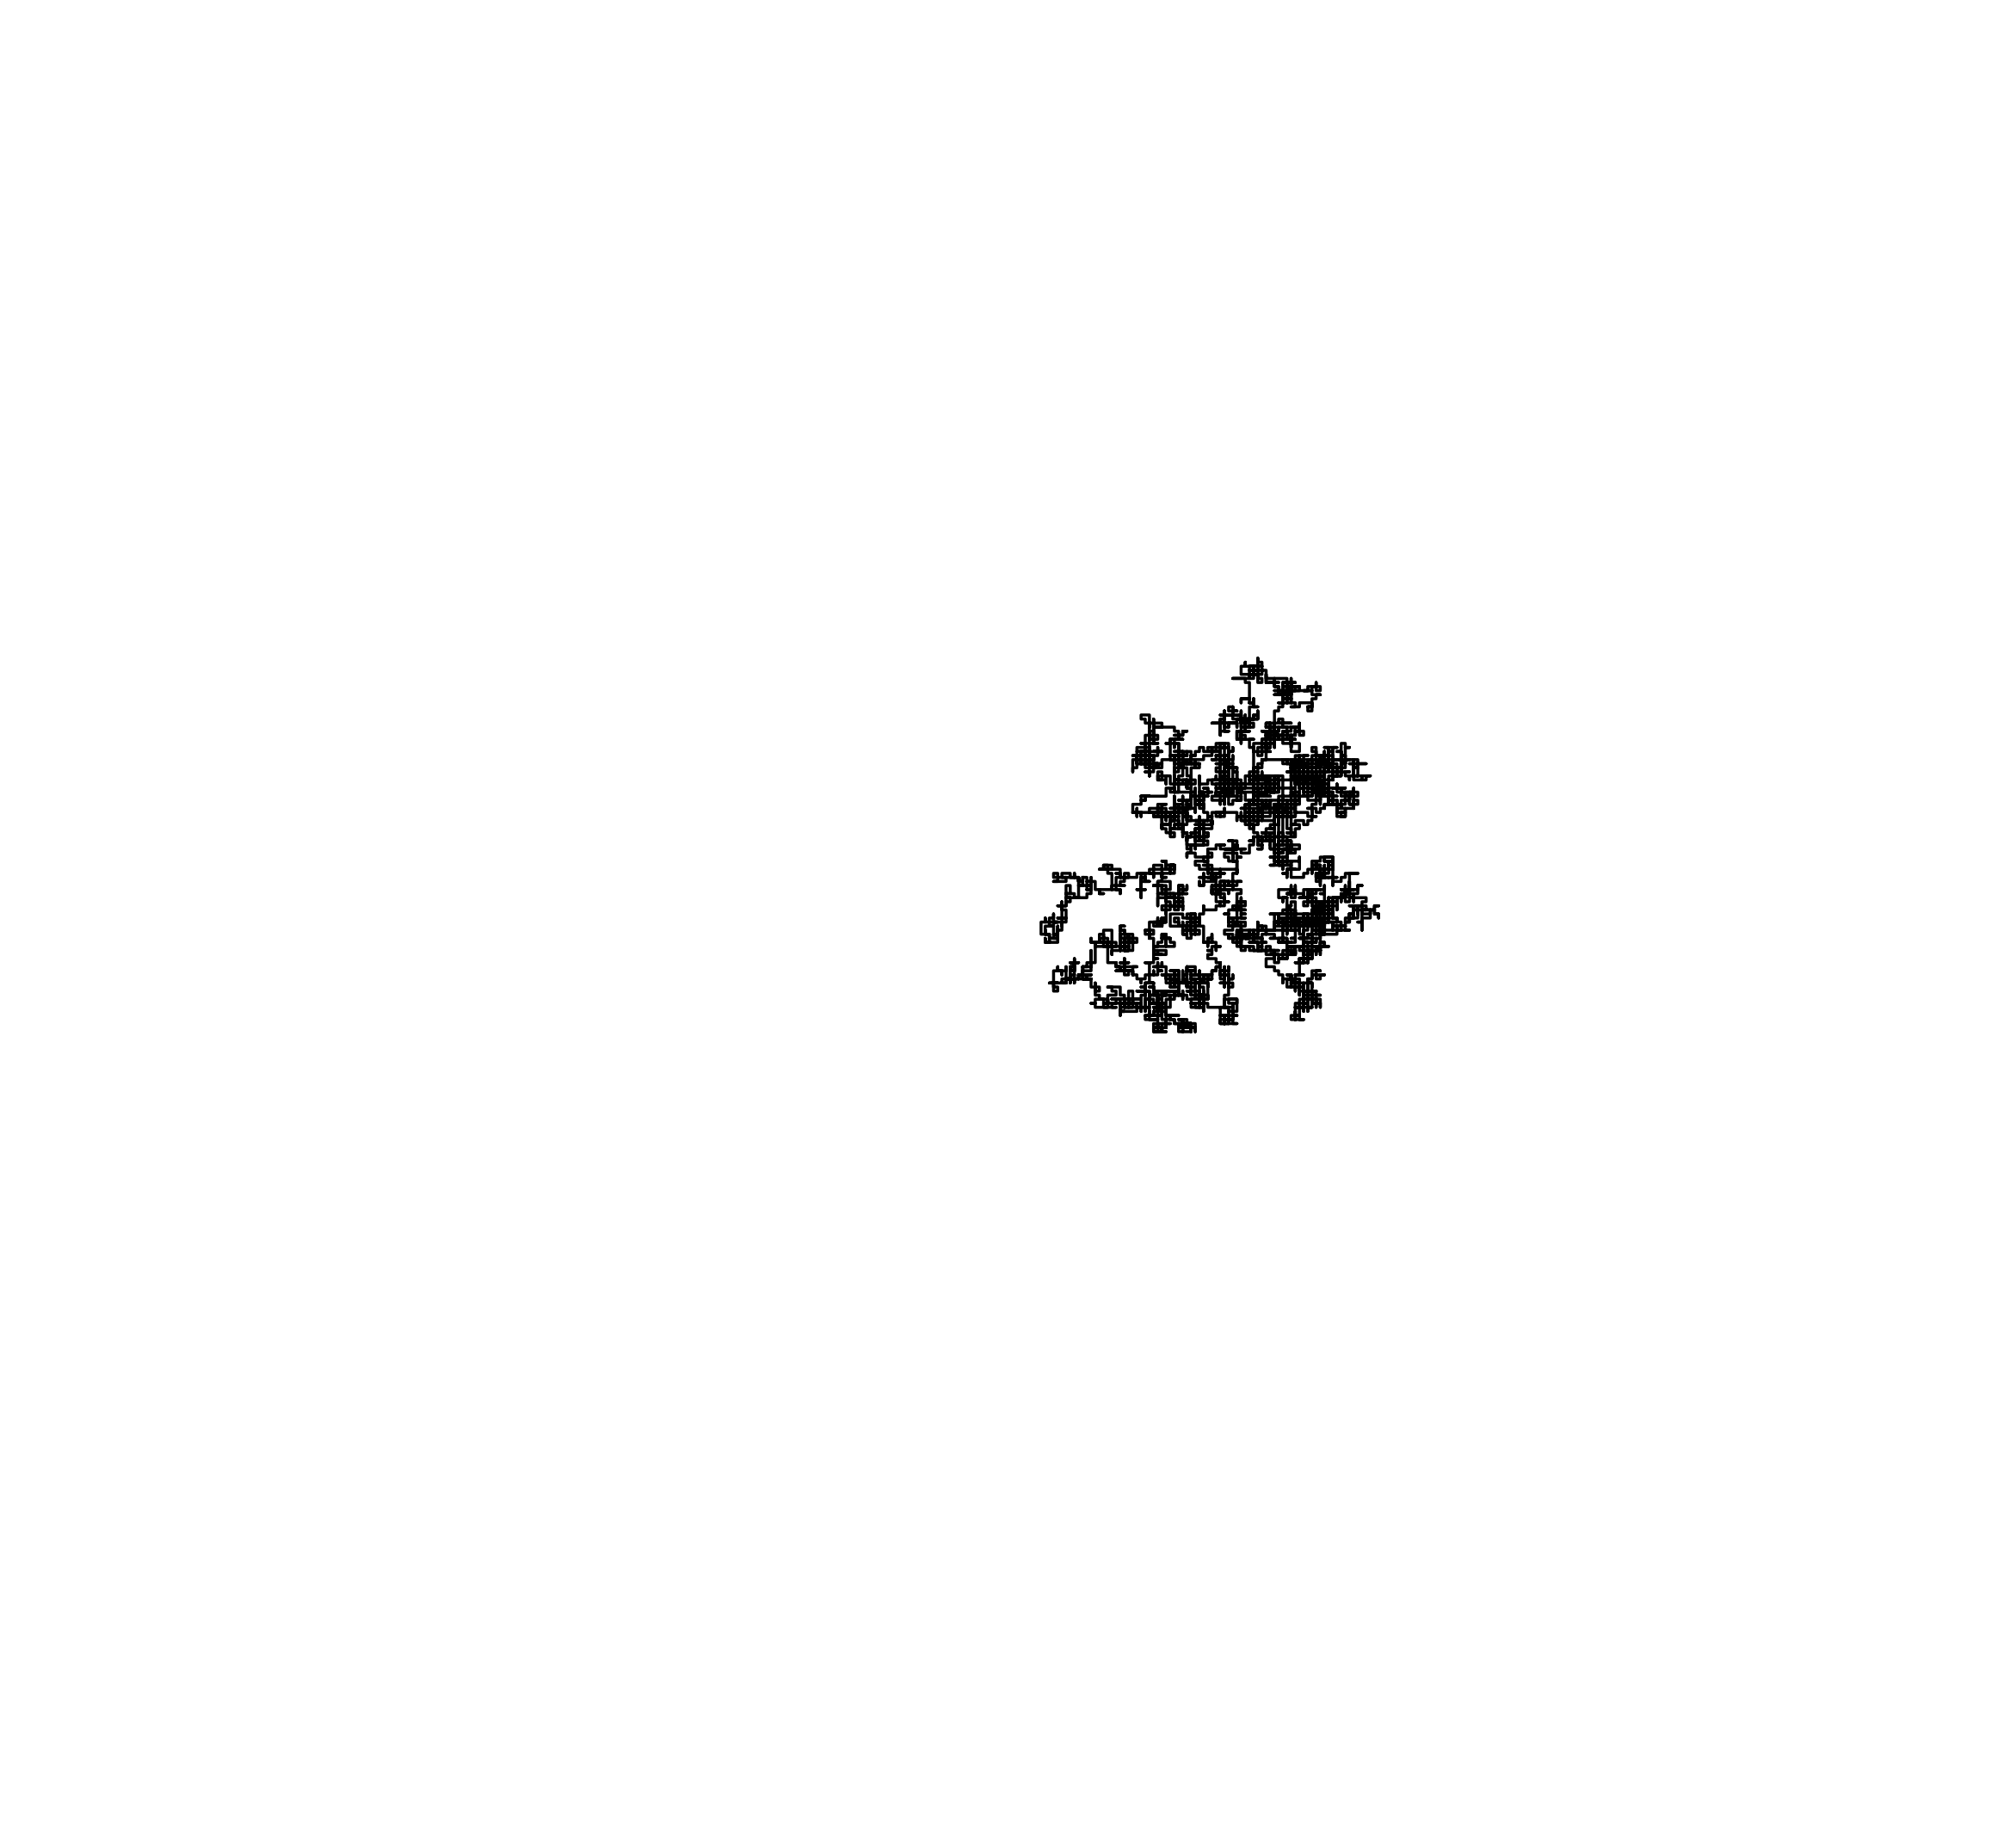

In [42]:
x, y = random_walk(nsteps = 9000)
fig, ax = plt.subplots(figsize=(5,5), dpi=500)
ax.axis('off')
ax.plot(x, y, c='k', linewidth=0.5)
ax.set_xlim([-200,200])
ax.set_ylim([-200,200])